# Fake News Detection

This project aims to provide a solution to the problem of distinguishing real and fake news. 

In [144]:
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import time
import string
import nltk
from nltk.corpus import stopwords 

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, precision_score, recall_score, plot_confusion_matrix

## Data import and cleaning

In [2]:
## Data sets from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
df_fake = pd.read_csv('data/Fake.csv')
df_real = pd.read_csv('data/True.csv')

df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [12]:
## Label article types
df_fake['label'] = 'FAKE'
df_real['label'] = 'REAL'

df = shuffle(pd.concat([df_fake, df_real])) # combine and shuffle data
df.drop(['date'],axis=1,inplace=True) # drop not needed for current analysis
df = df.dropna(axis=0).reset_index(drop=True)

stops = stopwords.words('english')
for col in ['title', 'text']: 
    df[col] = df[col].str.lower() # convert to lowercase for consistency
    df[col] = df[col].apply(lambda s: s.translate(str.maketrans('', '', string.punctuation))) # strip punctuation   
    df[col] = df[col].apply(lambda s: ' '.join([word for word in s.split() if word not in (stops)])) # exclude common words

print('Data contains', df.size, 'labeled news articles')
df.head()

Data contains 179592 labeled news articles


,title,text,subject,label
0,china partly lifts ban group tours south korea...,seoulbeijing reuters china allow travel agenci...,worldnews,REAL
1,great see trump told time sing national anthem...,saw live today fantastic difference special mo...,politics,FAKE
2,wow donald trump hammers obama “terrible deal ...,bravo spot onclick picture watch terrible deal...,Government News,FAKE
3,mueller’s latest request russia investigation ...,special counsel robert mueller dropped yet ano...,News,FAKE
4,breaking news sebastian gorka out…are ivanka j...,update white house official says sebastian gor...,left-news,FAKE


In [68]:
labels = df['label']

# Proof of Model Concept

In [141]:
vectorizer = TfidfVectorizer()

splits = 3
kf = KFold(n_splits=splits)

df_sample = df.head(n=10000)

### Text Model

[[1675   40]
 [  21 1598]]
[[1654   37]
 [  14 1628]]
[[1703   24]
 [  25 1581]]
Time to run: 212.0901861190796


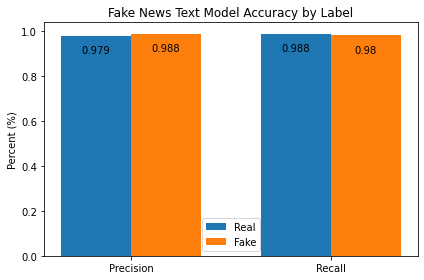

In [146]:
text_start = time.time() ## start timer

text_features = vectorizer.fit_transform(df_sample['text'])
labels = df_sample['label']

precision_real, recall_real  = 0, 0 
precision_fake, recall_fake = 0, 0

for train, test in kf.split(text_features):
    model = SVC()
    model.fit(text_features[train], labels.iloc[train]) # trains the data   
    predicts =  model.predict(text_features[test])  # tests and predicts        
    
    print(metrics.confusion_matrix(labels[test].tolist(), predicts))

    report = classification_report(labels[test], predicts, output_dict=True)
    precision_real += report.get('REAL').get('precision')
    recall_real += report.get('REAL').get('recall')
    precision_fake += report.get('FAKE').get('precision')
    recall_fake += report.get('FAKE').get('recall')
    
# calculate avg precision and recall from the n random samples
precision_real /= splits
precision_fake /= splits
recall_real /= splits
recall_fake /= splits

text_end = time.time()
print("Time to run:", text_end - text_start)

# Avg Precision-Accuracy graph ----------------------------------------------------------------------
labels = ['Precision', 'Recall']
decimal_places = 3
real = (round(precision_real, decimal_places), round(recall_real, decimal_places))
fake = (round(precision_fake, decimal_places), round(recall_fake, decimal_places))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, fake, width, label='Fake')

ax.set_ylabel('Percent (%)')
ax.set_title('Fake News Text Model Accuracy by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

### Title Model Concept

As seen above, the text based prediction model is quite time intensive. This model is checking whether a model using only the title of the article has a sufficient accuracy.

[[1553  162]
 [  78 1541]]
[[1556  135]
 [  98 1544]]
[[1565  162]
 [  78 1528]]
Time to run: 16.68315815925598


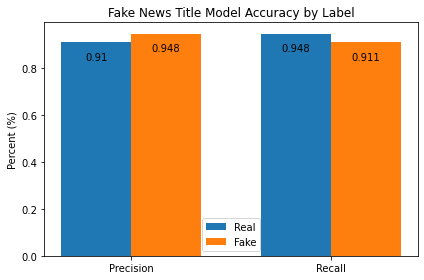

In [147]:
text_start = time.time() ## start timer

title_features = vectorizer.fit_transform(df_sample['title'])
labels = df['label']

precision_real, recall_real  = 0, 0 
precision_fake, recall_fake = 0, 0

for train, test in kf.split(title_features):
    model = SVC()
    model.fit(title_features[train], labels.iloc[train]) # trains the data  
    predicts =  model.predict(title_features[test])  # tests and predicts        
    
    print(metrics.confusion_matrix(labels[test].tolist(), predicts))

    report = classification_report(labels[test], predicts, output_dict=True)
    precision_real += report.get('REAL').get('precision')
    recall_real += report.get('REAL').get('recall')
    precision_fake += report.get('FAKE').get('precision')
    recall_fake += report.get('FAKE').get('recall')
    
# calculate avg precision and recall from the n random samples
precision_real /= splits
precision_fake /= splits
recall_real /= splits
recall_fake /= splits

text_end = time.time()
print("Time to run:", text_end - text_start)

# Avg Precision-Accuracy graph ----------------------------------------------------------------------
labels = ['Precision', 'Recall']
decimal_places = 3
real = (round(precision_real, decimal_places), round(recall_real, decimal_places))
fake = (round(precision_fake, decimal_places), round(recall_fake, decimal_places))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, fake, width, label='Fake')

ax.set_ylabel('Percent (%)')
ax.set_title('Fake News Title Model Accuracy by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

**After testing each of the models multiple times, we find the accuracy to be sufficient for our intended purposes.**

# Creating Models

In [188]:
df_final = df.head(1000)
final_labels = df_final['label']

In [ ]:
def train_text__model():
    model = SVC()
    model.fit(vectorizer.fit_transform(df_sample['text']), df_sample['label'])
    return model

text_model = train_text__model()

print("Model based on article text created.")

In [174]:
title_features = vectorizer.fit_transform(df_final['title'])
title_model = SVC()
title_model.fit(title_features, final_labels)

print("Model based on article title created.")

Model based on article title created.


# Web Scraping and Formatting

In [178]:
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

# Test Article by Text

In [184]:
article = 'https://www.cnn.com/2020/08/12/politics/kamala-harris-pronunciation/index.html'
# article = input("Copy and Paste article url: ")
try:
    html = urllib.request.urlopen(article).read()
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text().strip()
except: # if website blocks  from scraping, ask user for title of website
    print('Unable to access url of article.')
    title = input("Copy and paste Title Name: ")
    text = input("Copy and paste Article Text: ")

    data = [[text.lstrip()]]
df2 = pd.DataFrame(data, columns = ['text'])

article_text = vectorizer.transform(df2['text'])
result = text_model.predict(article_text)

# if result == ['FAKE']:
#     print ('This article is fake. Find a better source.')
# elif result == ['REAL']:
#     print ('This article is real. You can trust this source.')
# else:
#     print ('There is an error.')

ValueError: X.shape[1] = 13231 should be equal to 99013, the number of features at training time

# Test Article by Title

In [15]:
try:
    html = urllib.request.urlopen(input("Copy and Paste article url: ")).read()
    soup = BeautifulSoup(html, 'html.parser')
    title = soup.find('title').get_text()
    text = html_to_text(html)
except: # if website blocks  from scraping, ask user for title of website
    print('Unable to access url of article.')
    title = input("Copy and Paste Title Name: ")
    text = input("Copy and Paste Article Text: ")
    
    
data = [[title]]
df2 = pd.DataFrame(data, columns = ['title'])


article_title = vectorizer.transform(df2['title'])
result2 = text_model.predict(article_title)

Copy and Paste article url: https://www.cnn.com/2020/08/12/politics/kamala-harris-pronunciation/index.html


In [16]:
if result2 == ['FAKE']:
    print ('This article is fake. Find a better source.')
elif result2 == ['REAL']:
    print ('This article is real. You can trust this source.')
else:
    print ('There is an error.')

This article is real. You can trust this source.
